In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
from data_reader import read_data
from node import get_node_data
import pandas as pd
import numpy as np

In [3]:
raw_data = read_data(dataset="gnfuv")
# nodes = {"pi"+str(i+2):i for i in range(4)}
nodes = ["pi2", "pi3", "pi4", "pi5"]

In [4]:
for experiment in range(1,4):
    exp = raw_data.loc[raw_data.experiment == experiment]
    for node in nodes:
        node_data = exp.loc[exp.pi==node]
        print(len(node_data), end = " ")
        print(f"{node_data.temperature.min()} {node_data.temperature.max()} {round(node_data.temperature.mean(),2)} {round(node_data.temperature.std(),2)}", end =" ")
        print(f"{node_data.humidity.min()} {node_data.humidity.max()} {round(node_data.humidity.mean(),2)} {round(node_data.humidity.std(),2)}")
    print()

1532 3 45 35.85 6.57 15 57 27.6 11.08
899 19 33 28.53 4.39 34 59 43.04 6.17
1766 18 45 35.47 6.55 0 64 28.2 11.71
2078 18 37 27.51 5.1 20 63 39.78 6.9

580 26 56 48.48 6.6 21 49 28.42 3.86
807 27 49 41.73 4.14 17 46 23.41 5.66
1021 30 59 50.56 6.4 16 36 22.76 2.76
1407 30 48 40.13 2.73 20 49 28.05 3.36

342 33 42 38.39 2.39 17 31 23.44 4.09
264 27 33 31.95 0.77 34 43 38.63 1.26
488 20 39 31.24 5.31 23 59 38.28 10.56
555 21 37 25.23 3.91 20 47 38.13 4.65



## Visualising Data

In [4]:
data = {}
from similar import remove_outliers
for experiment in range(1,4):
    raw_node_data = get_node_data(raw_data, experiment)
    node_data = remove_outliers(raw_node_data.copy())
    min_samples = min([d.shape[0] for d in node_data])
    m = min_samples
    if min_samples*2/3 > 500:    
        m = int(min_samples*2/3)
    elif min_samples > 500:
        m = 500
    print([d.shape[0] for d in node_data], m)
    sampled_node_data = node_data.copy()
    for i in range(4):
        sampled_node_data[i] = node_data[i].sample(m).reset_index(drop=True)
    data[experiment] = {"sampled_data" : sampled_node_data, "all_data" : node_data}

[1418, 750, 1631, 1874] 500
[507, 677, 964, 1255] 500
[318, 232, 417, 481] 232


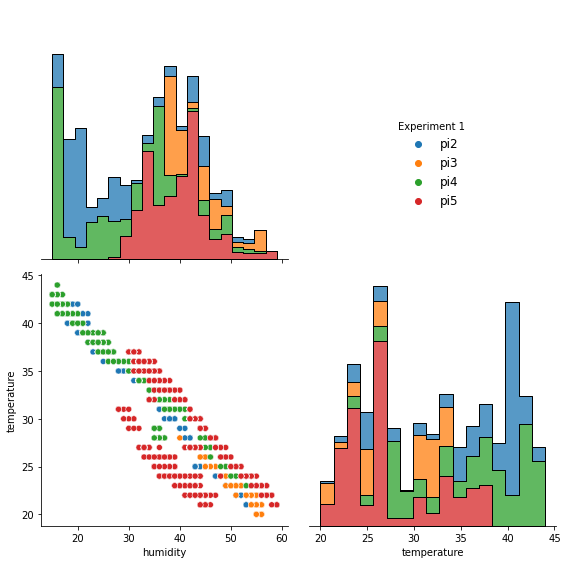

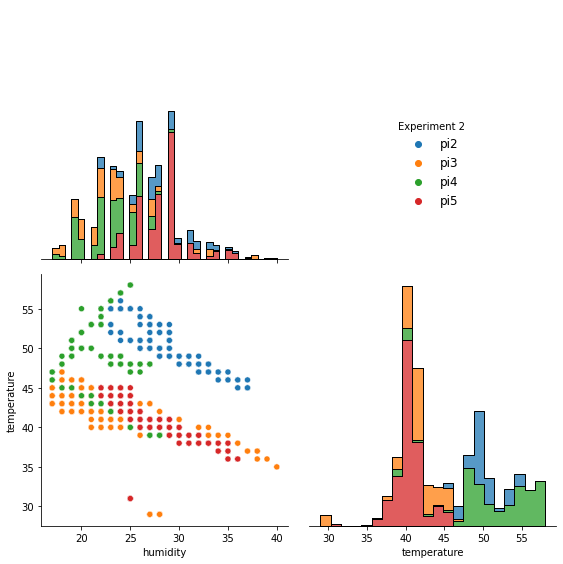

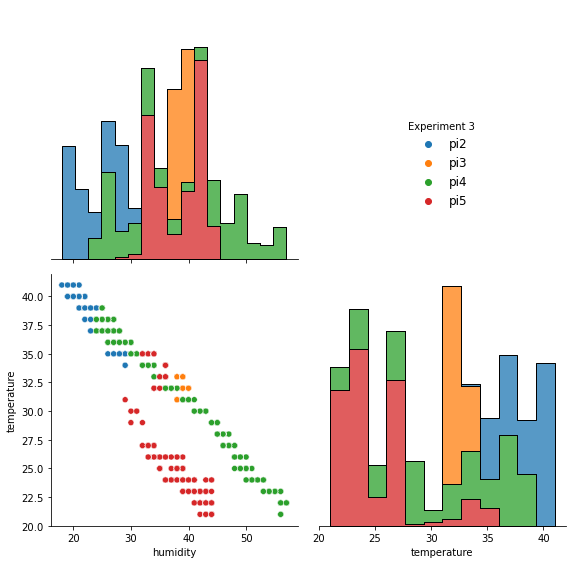

In [5]:
from visualising import pairplot_experiment
pairplot_experiment(data[1]["all_data"])
pairplot_experiment(data[2]["all_data"])
pairplot_experiment(data[3]["all_data"])

In [6]:
from sklearn.preprocessing import StandardScaler
def standardise_raw_data():
    std_data ={}
    for experiment in range(1,4):
        node_data = data[experiment]["all_data"]
        scaler = StandardScaler()
        experiment_std_data = [pd.DataFrame(columns = ["humidity", "temperature"],
                                          data = scaler.fit_transform(node_data[i][["humidity", "temperature"]])) 
                             for i in range(4)]
        i = 2
        for df in experiment_std_data:
            df["experiment"] = experiment
            df["std"] = True
            df["pi_std"] = "pi" + str(i)
            i = i + 1
        std_data[experiment] = experiment_std_data
    return std_data
std_data = standardise_raw_data()

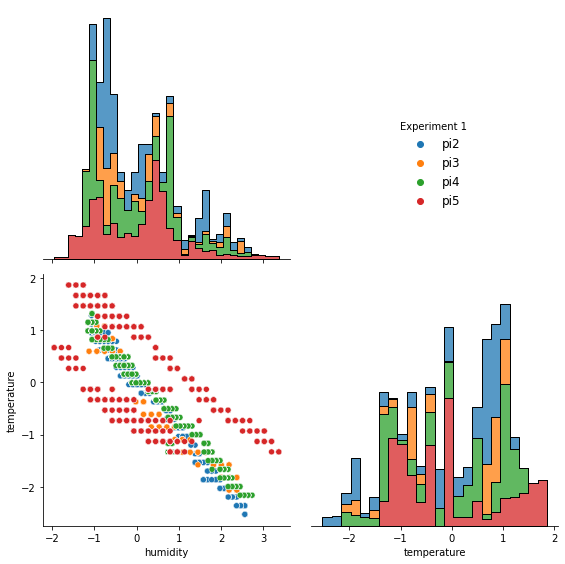

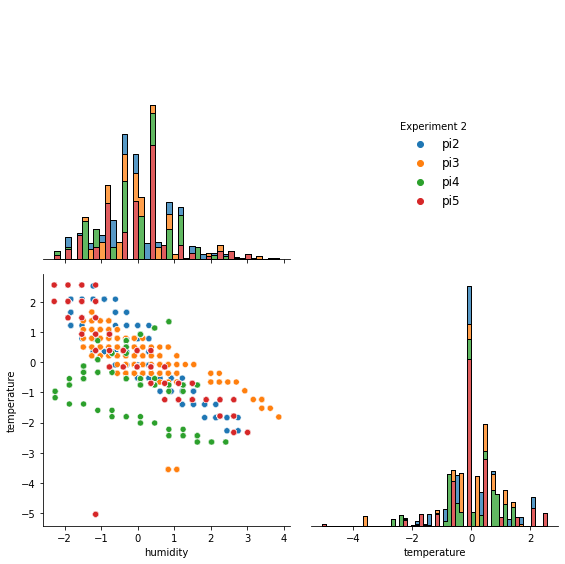

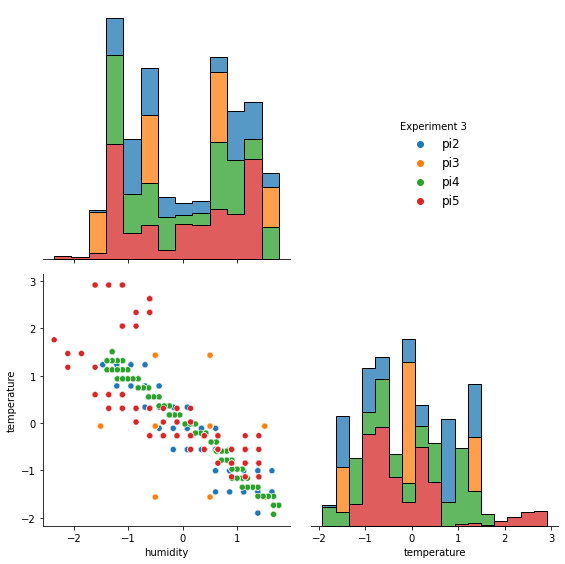

In [7]:
pairplot_experiment(std_data[1])
pairplot_experiment(std_data[2])
pairplot_experiment(std_data[3])

## Similarity MMD

In [52]:
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable

def bandwidth_experiment(samples, similar_nodes, other_nodes, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASDMMD(samples, similar_nodes, other_nodes, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

### Experiment 1

Nodes pi2 and pi4 are similar according to mmd and nodes pi3 and pi5 are similar to each other but not to the others

In [62]:
from maximum_mean_discrepancy import get_tensor_samples
tensor_samples = get_tensor_samples(data[1]["sampled_data"], sample_size=sample_sizes[0])

In [63]:
similar_nodes = ["pi2","pi4"]
other_nodes = ["pi3","pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+--------------------+
|     Nodes      |    Similar MMD     |
+----------------+--------------------+
| ('pi2', 'pi4') | 1.3750762939453125 |
+----------------+--------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi3', 'pi2') | 29.179397583007812 |
| ('pi3', 'pi4') | 35.089630126953125 |
| ('pi5', 'pi2') |  20.8682861328125  |
| ('pi5', 'pi4') | 25.835586547851562 |
| ('pi3', 'pi5') | 2.6141815185546875 |
+----------------+--------------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi4') | 4.1251220703125 |
+----------------+-----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi3', 'pi2') | 87.5382080078125 |
| ('pi3', 'pi4') | 105.268798828125 |
| ('pi5', 'pi2') | 62.6048583984375 |
| ('pi5', 'pi4') 

similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

In [64]:
tensor_samples = get_tensor_samples(std_data[1], sample_size=sample_sizes[0])

In [68]:
similar_nodes = ["pi2","pi3","pi4"]
other_nodes = ["pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "rbf")

LINEAR 

+----------------+------------------------+
|     Nodes      |      Similar MMD       |
+----------------+------------------------+
| ('pi2', 'pi3') | 0.0011867765570059419  |
| ('pi2', 'pi4') | 2.189068982261233e-05  |
| ('pi3', 'pi4') | 0.0009323577396571636  |
| ('pi5', 'pi2') | 0.0006115565774962306  |
| ('pi5', 'pi3') | 0.00014020566595718265 |
| ('pi5', 'pi4') | 0.00041372491978108883 |
+----------------+------------------------+
+-------+----------------+
| Nodes | Dissimilar MMD |
+-------+----------------+
+-------+----------------+

+----------------+-----------------------+
|     Nodes      |      Similar MMD      |
+----------------+-----------------------+
| ('pi2', 'pi3') | 0.0035603316500782967 |
| ('pi2', 'pi4') | 6.567034142790362e-05 |
| ('pi3', 'pi4') |  0.002797073917463422 |
| ('pi5', 'pi2') | 0.0018346661236137152 |
| ('pi5', 'pi3') | 0.0004206171724945307 |
| ('pi5', 'pi4') |  0.001241173013113439 |
+----------------+-----------------------+
+-------+---

### Experiment 3

Nodes pi3, pi4, pi5 are dissimilar with pi2. Nodes pi3 and pi4 are similar to each other and similar to pi5.

In [69]:
tensor_samples = get_tensor_samples(data[3]["sampled_data"], sample_size=sample_sizes[2])

In [70]:
similar_nodes = ["pi2", "pi4"]
other_nodes = ["pi3", "pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+--------------------+
|     Nodes      |    Similar MMD     |
+----------------+--------------------+
| ('pi2', 'pi4') | 28.566131591796875 |
| ('pi3', 'pi4') |  4.40692138671875  |
| ('pi5', 'pi4') | 9.591445922851562  |
| ('pi3', 'pi5') | 9.904647827148438  |
+----------------+--------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi3', 'pi2') | 31.458526611328125 |
| ('pi5', 'pi2') | 48.74272155761719  |
+----------------+--------------------+

+----------------+-------------------+
|     Nodes      |    Similar MMD    |
+----------------+-------------------+
| ('pi2', 'pi4') | 85.69854736328125 |
| ('pi3', 'pi4') |  13.220947265625  |
| ('pi5', 'pi4') | 28.77447509765625 |
| ('pi3', 'pi5') | 29.71405029296875 |
+----------------+-------------------+
+----------------+-------------------+
|     Nodes      |   Dissimilar MMD  |
+----------------+-------------------+
|

similar_sets = ["pi2", "pi3", "pi4"]
dissimilar_sets = ["pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

In [85]:
tensor_samples = get_tensor_samples(std_data[3], sample_size=sample_sizes[2])

In [86]:
similar_nodes = ["pi2", "pi4"]
other_nodes = ["pi3", "pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(10, 50, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1, 5 , 4), "rbf")

LINEAR 

+----------------+------------------------+
|     Nodes      |      Similar MMD       |
+----------------+------------------------+
| ('pi2', 'pi4') | -8.741480428398063e-08 |
| ('pi3', 'pi2') | -3.462572806256503e-07 |
| ('pi3', 'pi5') | -2.604793394311855e-07 |
+----------------+------------------------+
+----------------+-------------------------+
|     Nodes      |      Dissimilar MMD     |
+----------------+-------------------------+
| ('pi3', 'pi4') | -1.6092607779683021e-07 |
| ('pi5', 'pi2') |  1.464210299673141e-07  |
| ('pi5', 'pi4') |  -1.751254075088582e-08 |
+----------------+-------------------------+

+----------------+-------------------------+
|     Nodes      |       Similar MMD       |
+----------------+-------------------------+
| ('pi2', 'pi4') |  -8.975769674179901e-07 |
| ('pi3', 'pi2') | -1.4966715298214694e-06 |
+----------------+-------------------------+
+----------------+------------------------+
|     Nodes      |     Dissimilar MMD     |
+--------

### Experiment 2

In [25]:
tensor_samples = get_tensor_samples(data[2]["sampled_data"], sample_size=sample_sizes[1])

In [26]:
similar_nodes = ["pi3", "pi5"]
other_nodes = ["pi2", "pi4"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(5,100 , 5), "rbf")

LINEAR 

+----------------+-------------------+
|     Nodes      |    Similar MMD    |
+----------------+-------------------+
| ('pi3', 'pi5') | 4.380279541015625 |
+----------------+-------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi2', 'pi3') | 12.232162475585938 |
| ('pi2', 'pi5') | 11.631454467773438 |
| ('pi4', 'pi3') | 12.050918579101562 |
| ('pi4', 'pi5') | 16.890335083007812 |
| ('pi2', 'pi4') | 5.491302490234375  |
+----------------+--------------------+

+----------------+-------------------+
|     Nodes      |    Similar MMD    |
+----------------+-------------------+
| ('pi3', 'pi5') | 13.14080810546875 |
+----------------+-------------------+
+----------------+-------------------+
|     Nodes      |   Dissimilar MMD  |
+----------------+-------------------+
| ('pi2', 'pi3') | 36.69635009765625 |
| ('pi2', 'pi5') |   34.89404296875  |
| ('pi4', 'pi3') | 36.15289306640625 |
| ('pi

In [87]:
tensor_samples = get_tensor_samples(std_data[2], sample_size=sample_sizes[1])

In [92]:
similar_nodes = ["pi2", "pi3", "pi5"]
other_nodes = ["pi4"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.5, 2, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1,1 , 5), "rbf")

LINEAR 

+----------------+------------------------+
|     Nodes      |      Similar MMD       |
+----------------+------------------------+
| ('pi2', 'pi3') | 1.8753909536428637e-10 |
| ('pi2', 'pi5') | -3.545031490581607e-10 |
| ('pi3', 'pi5') | -4.715672852206865e-10 |
+----------------+------------------------+
+----------------+------------------------+
|     Nodes      |     Dissimilar MMD     |
+----------------+------------------------+
| ('pi4', 'pi2') | 2.2520056930375176e-09 |
| ('pi4', 'pi3') | 6.708955169187902e-09  |
| ('pi4', 'pi5') | 5.883830755948338e-09  |
+----------------+------------------------+

+----------------+------------------------+
|     Nodes      |      Similar MMD       |
+----------------+------------------------+
| ('pi2', 'pi3') | 3.7507819072857274e-10 |
| ('pi2', 'pi5') | -7.090062981163214e-10 |
| ('pi3', 'pi5') | -9.43134570441373e-10  |
+----------------+------------------------+
+----------------+------------------------+
|     Nodes      |    